In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc
import keras
import tensorflow as tf
from keras import metrics
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.metrics import AUC
from keras.optimizers import Adam,SGD
import os

2024-04-22 06:17:54.462139: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 06:17:54.462241: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 06:17:54.741408: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dataset_path = "/kaggle/input/chest-xray-pneumonia"
train_path = dataset_path + "/chest_xray/train/"
val_path = dataset_path+ "/chest_xray/val/"
test_path = dataset_path + "/chest_xray/test/"

In [3]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0, 
                                   shear_range = 0.2,
                                   zoom_range = 0.2, 
                                   horizontal_flip = True,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,)
val_datagen = ImageDataGenerator(rescale=1.0/255.0) 
test_datagen = ImageDataGenerator(rescale=1.0/255.0) 

In [4]:
train_generator = train_datagen.flow_from_directory(directory = train_path, 
                                                    target_size = (224, 224),
                                                    batch_size = 128, 
                                                    color_mode = 'rgb',
                                                    class_mode = 'binary', 
                                                    seed = 42)
val_generator = val_datagen.flow_from_directory(directory = val_path, 
                                                 target_size = (224, 224),
                                                 batch_size = 128, 
                                                 class_mode = 'binary',
                                                 color_mode = 'rgb',
                                                 shuffle=False,
                                                 seed = 42)
test_generator = test_datagen.flow_from_directory(directory = test_path, 
                                                 target_size = (224, 224),
                                                 batch_size = 128, 
                                                 class_mode = 'binary',
                                                 color_mode = 'rgb',
                                                 shuffle=False,
                                                 seed = 42)
test_generator.reset()

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


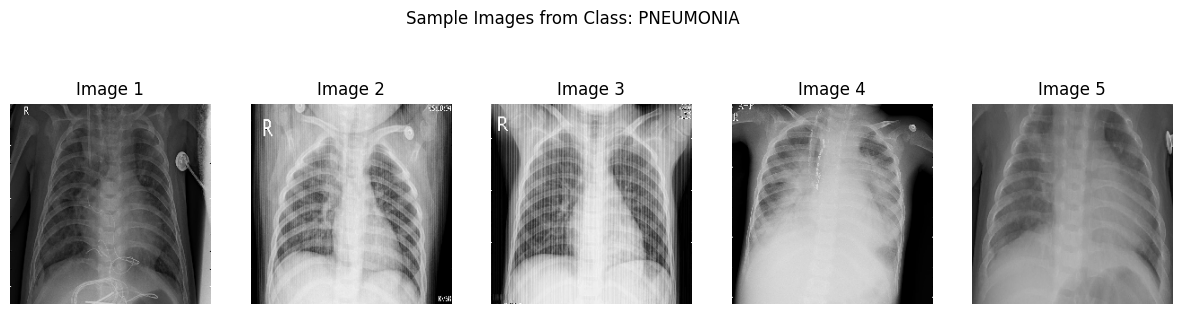

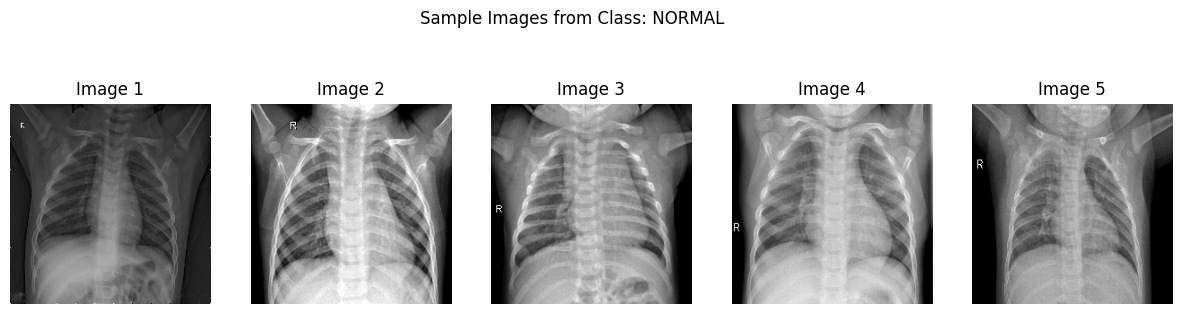

In [5]:
def plot_sample_images(directory, num_images=5):
    class_dirs = [os.path.join(directory, cls) for cls in os.listdir(directory)]
    
    for cls_dir in class_dirs:
        class_name = os.path.basename(cls_dir)
        fig, axes = plt.subplots(1, num_images, figsize=(15, 4))
        fig.suptitle(f'Sample Images from Class: {class_name}')
        
        # Load and plot sample images
        image_files = [os.path.join(cls_dir, file) for file in os.listdir(cls_dir)[:num_images]]
        for i, image_file in enumerate(image_files):
            image = load_img(image_file, target_size=(224, 224))  # Load and resize image
            axes[i].imshow(image)
            axes[i].set_title(f'Image {i+1}')
            axes[i].axis('off')
        plt.show()
plot_sample_images(train_path)

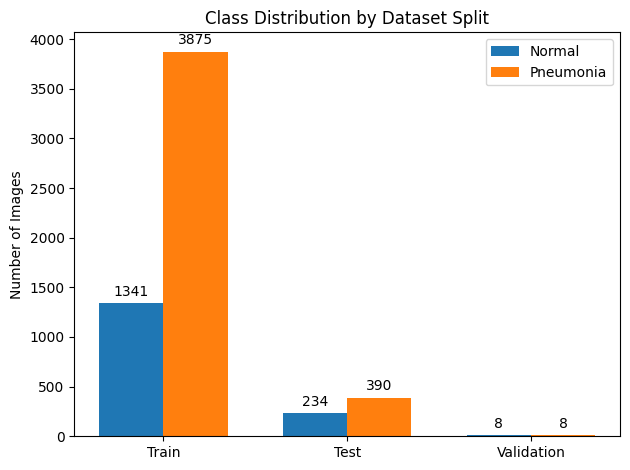

In [6]:
def count_images_in_classes(directory):
    num_normal = len(os.listdir(os.path.join(directory, 'NORMAL')))
    num_pneumonia = len(os.listdir(os.path.join(directory, 'PNEUMONIA')))
    return num_normal, num_pneumonia

train_normal, train_pneumonia = count_images_in_classes(train_path)
test_normal, test_pneumonia = count_images_in_classes(test_path)
validation_normal, validation_pneumonia = count_images_in_classes(val_path)

labels = ['Train', 'Test', 'Validation']
normal_counts = [train_normal, test_normal, validation_normal]
pneumonia_counts = [train_pneumonia, test_pneumonia, validation_pneumonia]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, normal_counts, width, label='Normal')
rects2 = ax.bar(x + width/2, pneumonia_counts, width, label='Pneumonia')
ax.set_ylabel('Number of Images')
ax.set_title('Class Distribution by Dataset Split')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.show()

Found 5216 images belonging to 2 classes.


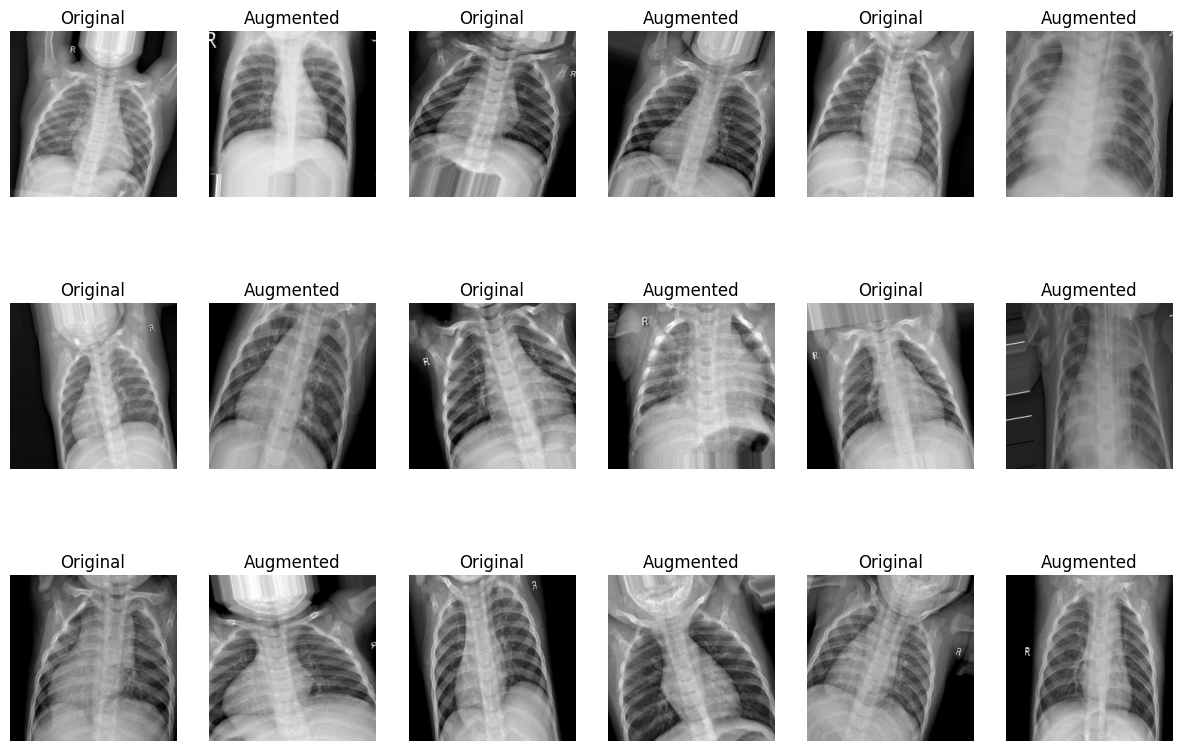

In [7]:
original_images, _ = next(train_datagen.flow_from_directory(
    train_path,
    target_size=(224,224),
    batch_size=9,
    class_mode='binary',
    shuffle=False
))

augmented_images, _ = next(train_generator)

plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3, 6, 2*i + 1)
    plt.imshow(original_images[i])
    plt.title('Original')
    plt.axis('off')

    plt.subplot(3, 6, 2*i + 2)
    plt.imshow(augmented_images[i])
    plt.title('Augmented')
    plt.axis('off')

plt.show()

In [8]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001),  loss='binary_crossentropy',  metrics=[AUC()])

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
history = model.fit(train_generator, 
                    steps_per_epoch = len(train_generator),
                    epochs = 40, 
                    validation_data = val_generator,
                    validation_steps = len(val_generator), 
                    verbose=1, batch_size=32)

Epoch 1/40


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-04-22 06:19:19.557840: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=1,k3=0} for conv (f32[128,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-22 06:19:19.697141: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.139420956s
Trying algo

32/41 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - auc: 0.7929 - loss: 0.5327

W0000 00:00:1713767047.482410     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 360s 5s/step - auc: 0.8180 - loss: 0.4944 - val_auc: 0.9141 - val_loss: 0.4612
Epoch 2/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/40


W0000 00:00:1713767071.391204     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


41/41 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - auc: 0.9649 - loss: 0.2112 - val_auc: 0.9531 - val_loss: 0.5372
Epoch 4/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - auc: 0.9808 - loss: 0.1557 - val_auc: 0.9844 - val_loss: 0.4526
Epoch 6/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - auc: 0.9821 - loss: 0.1508 - val_auc: 0.9844 - val_loss: 0.2297
Epoch 8/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - auc: 0.9860 - loss: 0.1339 - val_auc: 0.9844 - val_loss: 0.3642
Epoch 10/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 

In [13]:
model.evaluate(test_generator)

W0000 00:00:1713769211.360946     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 780ms/step - auc: 0.7280 - loss: 0.3357

W0000 00:00:1713769215.124511     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 921ms/step - auc: 0.8061 - loss: 0.3053


[0.24462978541851044, 0.9623657464981079]

In [14]:
y_true = test_generator.classes
Y_pred = model.predict(test_generator, steps = len(test_generator))
y_pred = (Y_pred > 0.5).T[0]
y_pred_prob = Y_pred.T[0]
cm = confusion_matrix(y_true, y_pred)

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 923ms/step


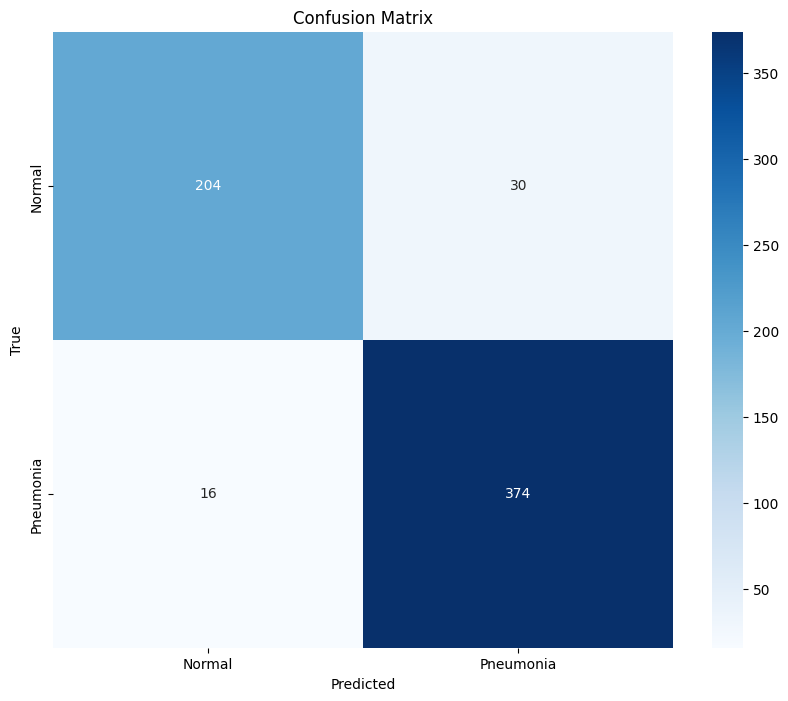

In [15]:
import seaborn as sns
class_labels = ['Normal', 'Pneumonia']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [16]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90       234
           1       0.93      0.96      0.94       390

    accuracy                           0.93       624
   macro avg       0.93      0.92      0.92       624
weighted avg       0.93      0.93      0.93       624



In [17]:
names = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
labels = np.asarray(labels).reshape(2,2)
ticklabels = ['Normal', 'Pneumonia']

In [18]:
TN, FP, FN, TP = cm.ravel() 
accuracy = (TP + TN) / np.sum(cm) 
precision = TP / (TP+FP) 
recall =  TP / (TP+FN) 
specificity = TN / (TN+FP)
f1 = 2*precision*recall / (precision + recall)
stats_summary = 'Accuracy = {:.2%}  \nPrecision = {:.2%}  \nRecall = {:.2%}\nF1 Score = {:.2%}'.format(accuracy, precision, recall,f1)
print(stats_summary)

Accuracy = 92.63%  
Precision = 92.57%  
Recall = 95.90%
F1 Score = 94.21%
